In [23]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
from seaborn import set_style
set_style('whitegrid')

In [24]:
# Import the total state data csv and convert date to datetime format
df = pd.read_csv("../../../SharedData/total_state_data.csv")
df.date = pd.to_datetime(df.date)
df = df[(df.date.dt.year>=1995)&(df.date.dt.year<2020)] # Restrict to years between 1995 and 2020

# Restrict # of features in dataframe - only interested in monthly features for now
mo_features = ['state', 'date', 'monthly_emissions', 'monthly_population', 'prcp', 'snow', 'tavg',
       'gdp_rel_2017_interp', 'monthly_energy_prod', 'monthly_energy_use', 'monthly_energy_flow', 
       'monthly_num_plants', 'monthly_energy_renew', 'monthly_energy_fossil', 'monthly_energy_total', 
       'monthly_renew_pct', 'monthly_fossil_pct', 'state_sq_ft', 'monthly_pop_density']
df = df[mo_features]

# Create columns for per capita features:
df['co2_per_capita'] = df['monthly_emissions'] / df['monthly_population']
df['gdp_per_capita'] = df['gdp_rel_2017_interp'] / df['monthly_population']
df['eprod_per_capita'] = df['monthly_energy_prod'] / df['monthly_population']
df['euse_per_capita'] = df['monthly_energy_use'] / df['monthly_population']
df['num_plants_per_capita'] = df['monthly_num_plants'] / df['monthly_population']

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14400 entries, 2880 to 17279
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   state                  14400 non-null  object        
 1   date                   14400 non-null  datetime64[ns]
 2   monthly_emissions      14400 non-null  float64       
 3   monthly_population     14400 non-null  float64       
 4   prcp                   14334 non-null  float64       
 5   snow                   14334 non-null  float64       
 6   tavg                   14334 non-null  float64       
 7   gdp_rel_2017_interp    12720 non-null  float64       
 8   monthly_energy_prod    14400 non-null  float64       
 9   monthly_energy_use     14400 non-null  float64       
 10  monthly_energy_flow    14400 non-null  float64       
 11  monthly_num_plants     13248 non-null  float64       
 12  monthly_energy_renew   14400 non-null  float64       
 13  mon

Set up a dataframe consisting only of data from one state - in this case, DE. Then, we define our predicted variable and our potential features. Our goal is to try to reduce this list of features to those that are necessary.

In [25]:
# Make a new dataframe consisting of data from DE only 
df_de = df[df.state == "DE"].reset_index()

regr_predict = 'co2_per_capita' # Variable we will be predicting
regr_features = ['prcp', 'snow', 'tavg', 'gdp_per_capita', 'eprod_per_capita', # All our potential features
                 'euse_per_capita', 'num_plants_per_capita', 'monthly_renew_pct', 
                 'monthly_fossil_pct', 'monthly_pop_density']

Lasso does not deal well with NA values, so we will need to either drop all or set them to be 0. We will perform both, comparing their performance. First, we dropping all NA values, then we will fill them with 0s. 

In [26]:
# Drop all NA values
print("There are", df_de.shape[0], "total entries")
df_de_dropna = df_de.dropna()
print("After dropping all NA entries, there are now", df_de_dropna.shape[0], "total entries")

# Split the dataframe into 80% training values and 20% test values
train_size = 0.8
df_de_train = df_de_dropna.iloc[:int(len(df_de_dropna)*train_size)]
df_de_test = df_de_dropna.iloc[int(len(df_de_dropna)*train_size):]

There are 300 total entries
After dropping all NA entries, there are now 262 total entries


In [27]:
# List of potential alphas. We will test them all and compare the model's coefficients
alphas = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]

# The number of coefficients of the model
n = len(regr_features)

# List to hold our coefficient estimates
lasso_coefs = np.empty((len(alphas), n))

# for each alpha value
for i in range(len(alphas)):
    # set up the lasso pipeline: scale, then fit the lasso regression model
    lasso_pipe = Pipeline([('scale',StandardScaler()),
                              # ridge model here, max_iter=5000000,
                              ('lasso', Lasso(alpha=alphas[i], max_iter=5000000))])
    
    # Then fit the lasso pipeline with the training values
    lasso_pipe.fit(df_de_train[regr_features], df_de_train[regr_predict])
        
    # And record the coefficients
    lasso_coefs[i,:] = lasso_pipe['lasso'].coef_

In [28]:
print("Lasso Coefficients (Dropped NA):")
pd.DataFrame(np.round(lasso_coefs,8),
            columns = [feature for feature in regr_features],
            index = ["alpha=" + str(a) for a in alphas])

Lasso Coefficients (Dropped NA):


,prcp,snow,tavg,gdp_per_capita,eprod_per_capita,euse_per_capita,num_plants_per_capita,monthly_renew_pct,monthly_fossil_pct,monthly_pop_density
alpha=1e-05,-0.014182,0.040416,0.035446,-0.045497,0.003973,0.139731,0.049601,0.000242,-0.024071,-0.003732
alpha=0.0001,-0.014009,0.040119,0.035134,-0.044933,0.003052,0.136719,0.049718,0.000085,-0.023651,-0.001727
alpha=0.001,-0.012627,0.038324,0.033685,-0.043044,-0.000000,0.130306,0.049128,-0.000419,-0.020711,0.000000
alpha=0.01,-0.000000,0.019819,0.017986,-0.021979,-0.001531,0.095806,0.045228,-0.007232,-0.002902,0.008802
alpha=0.1,0.000000,0.000000,0.000000,0.000000,-0.000000,0.026882,0.000000,-0.000000,0.000000,0.000000
alpha=1,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000
alpha=10,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000
alpha=100,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000
alpha=1000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000


Now, we try fitting the Lasso model to the training data and compare the MSE's for each. Our goal is to choose the value of $\alpha$ that minimizes the MSE. 

In [29]:
# We perform CV with k=5 splits, and a holdout size of 12 for each split. 
n_splits = 5
test_size = 12
kfold = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

# Set up the list to hold the MSEs for each of the alphas and the CV splits
mses = np.empty((len(alphas),n_splits))

i=0
j=0
for alpha in alphas:
    for tt_ind, ho_ind in kfold.split(df_de_train):
        df_tt = df_de_train.iloc[tt_ind]
        df_ho = df_de_train.iloc[ho_ind]

        lasso_pipe = Pipeline([('scale',StandardScaler()), ('lasso', Lasso(alpha=alphas[i], max_iter=5000000))])
        lasso_pipe.fit(df_tt[regr_features], df_tt[regr_predict])
        lasso_preds = lasso_pipe.predict(df_ho[regr_features])
        mses[i,j] = mse(df_ho[regr_predict], lasso_preds)
        j+=1
    print(f'The Mean Squared Error for {alphas[i]} is {mses[i,:].mean():.4f}')    
    i+=1
    j=0

The Mean Squared Error for 1e-05 is 0.0953
The Mean Squared Error for 0.0001 is 0.0931
The Mean Squared Error for 0.001 is 0.0727
The Mean Squared Error for 0.01 is 0.0082
The Mean Squared Error for 0.1 is 0.0464
The Mean Squared Error for 1 is 0.0515
The Mean Squared Error for 10 is 0.0515
The Mean Squared Error for 100 is 0.0515
The Mean Squared Error for 1000 is 0.0515


We find that the Lasso model with $\alpha=0.01$ minimizes the MSE at 0.0082. Next, set up the model with the chosen value of $\alpha$ and find the MSE on the test data. 

In [30]:
alpha = 0.01

lasso_pipe = Pipeline([('scale',StandardScaler()), ('lasso', Lasso(alpha=alpha, max_iter=5000000))])
lasso_pipe.fit(df_de_dropna[regr_features], df_de_dropna[regr_predict])
lasso_preds = lasso_pipe.predict(df_de_dropna[regr_features])
test_mse = mse(df_de_dropna[regr_predict], lasso_preds)

print(f'The Test Mean Squared Error with alpha={alpha} is {test_mse:.4f}')    

The Test Mean Squared Error with alpha=0.01 is 0.0223


Text(0.5, 1.0, 'Delaware CO2 Emissions per Capita')

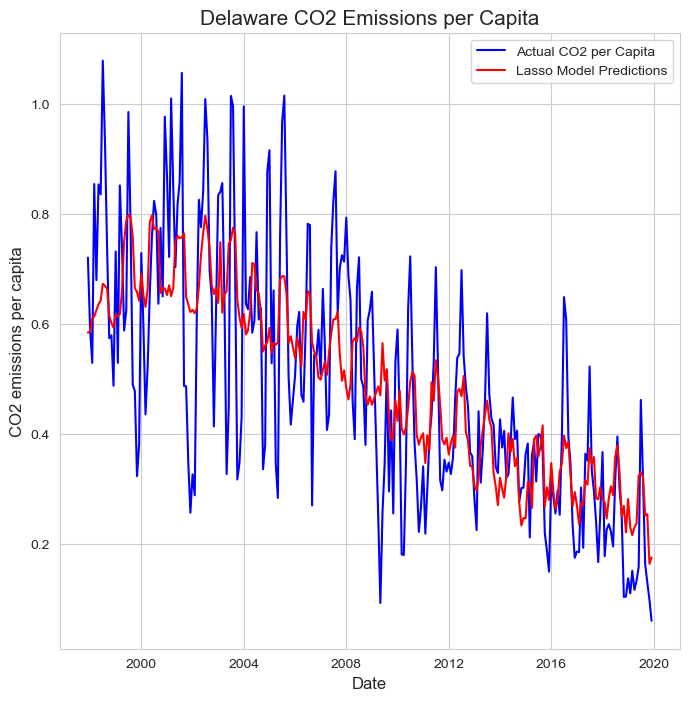

In [31]:
plt.figure(figsize=(8,8))

plt.plot(df_de_dropna['date'], df_de_dropna['co2_per_capita'], 'b-', label='Actual CO2 per Capita')
plt.plot(df_de_dropna['date'], lasso_preds, 'r-', label='Lasso Model Predictions')

plt.xlabel('Date', fontsize=12)
plt.ylabel('CO2 emissions per capita', fontsize=12)
plt.legend()

plt.title("Delaware CO2 Emissions per Capita", fontsize=15)


Next, we perform the same code but now starting off by setting all NA values to 0. 

In [32]:
# Set all NA values to 0
print("There are", df_de.shape[0], "total entries")
df_de_fillna = df_de.fillna(0)

# Split the dataframe into 80% training values and 20% test values
train_size = 0.8
df_de_train = df_de_fillna.iloc[:int(len(df_de_fillna)*train_size)]
df_de_test = df_de_fillna.iloc[int(len(df_de_fillna)*train_size):]

There are 300 total entries


In [33]:
# List of potential alphas. We will test them all and compare the model's coefficients
alphas = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]

# The number of coefficients of the model
n=len(regr_features)

# List to hold our coefficient estimates
lasso_coefs = np.empty((len(alphas),n))

# for each alpha value
for i in range(len(alphas)):
    # set up the lasso pipeline: scale, then fit the lasso regression model
    lasso_pipe = Pipeline([('scale',StandardScaler()),
                              # ridge model here, max_iter=5000000,
                              ('lasso', Lasso(alpha=alphas[i], max_iter=5000000))
                              ])
    
    # Then fit the lasso pipeline with the training values
    lasso_pipe.fit(df_de_train[regr_features], df_de_train[regr_predict])
        
    # And record the coefficients
    lasso_coefs[i,:] = lasso_pipe['lasso'].coef_

In [34]:
print("Lasso Coefficients (Filled NA):")

pd.DataFrame(np.round(lasso_coefs,8),
            columns = [feature for feature in regr_features],
            index = ["alpha=" + str(a) for a in alphas])

Lasso Coefficients (Filled NA):


,prcp,snow,tavg,gdp_per_capita,eprod_per_capita,euse_per_capita,num_plants_per_capita,monthly_renew_pct,monthly_fossil_pct,monthly_pop_density
alpha=1e-05,-0.011799,0.038133,0.060029,-0.049713,0.000377,0.097102,0.022799,0.012382,-0.031043,0.055917
alpha=0.0001,-0.011663,0.037944,0.059992,-0.049564,-0.000000,0.096775,0.022334,0.011782,-0.030331,0.055182
alpha=0.001,-0.010286,0.036096,0.059645,-0.047467,-0.000650,0.096916,0.017832,0.006110,-0.024804,0.047092
alpha=0.01,-0.000000,0.021374,0.049088,-0.024930,-0.002559,0.088225,0.000000,-0.000000,-0.000000,0.034057
alpha=0.1,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.017381,-0.000000,-0.000000,0.000000,0.019738
alpha=1,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000
alpha=10,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000
alpha=100,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000
alpha=1000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000


In [35]:
# We perform CV with k=5 splits, and a holdout size of 12 for each split. 
n_splits = 5
test_size = 12
kfold = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

# Set up the list to hold the MSEs for each of the alphas and the CV splits
mses = np.empty((len(alphas),n_splits))

i=0
j=0
for alpha in alphas:
    for tt_ind, ho_ind in kfold.split(df_de_train):
        df_tt = df_de_train.iloc[tt_ind]
        df_ho = df_de_train.iloc[ho_ind]

        lasso_pipe = Pipeline([('scale',StandardScaler()), ('lasso', Lasso(alpha=alphas[i], max_iter=5000000))])
        lasso_pipe.fit(df_tt[regr_features], df_tt[regr_predict])
        lasso_preds = lasso_pipe.predict(df_ho[regr_features])
        mses[i,j] = mse(df_ho[regr_predict], lasso_preds)
        j+=1
    print(f'The Mean Squared Error for {alphas[i]} is {mses[i,:].mean():.4f}')    
    i+=1
    j=0

The Mean Squared Error for 1e-05 is 0.0234
The Mean Squared Error for 0.0001 is 0.0223
The Mean Squared Error for 0.001 is 0.0139
The Mean Squared Error for 0.01 is 0.0113
The Mean Squared Error for 0.1 is 0.0584
The Mean Squared Error for 1 is 0.0681
The Mean Squared Error for 10 is 0.0681
The Mean Squared Error for 100 is 0.0681
The Mean Squared Error for 1000 is 0.0681


We find that the Lasso model with $\alpha=0.01$ minimizes the MSE at 0.0113. Next, set up the model with the chosen value of $\alpha$ and find the MSE on the test data. 

In [36]:
alpha = 0.01

lasso_pipe = Pipeline([('scale',StandardScaler()), ('lasso', Lasso(alpha=alpha, max_iter=5000000))])
lasso_pipe.fit(df_de_fillna[regr_features], df_de_fillna[regr_predict])
lasso_preds = lasso_pipe.predict(df_de_fillna[regr_features])
test_mse = mse(df_de_fillna[regr_predict], lasso_preds)

print(f'The Test Mean Squared Error with alpha={alpha} is {test_mse:.4f}')    

The Test Mean Squared Error with alpha=0.01 is 0.0231


Text(0.5, 1.0, 'Delaware CO2 Emissions per Capita')

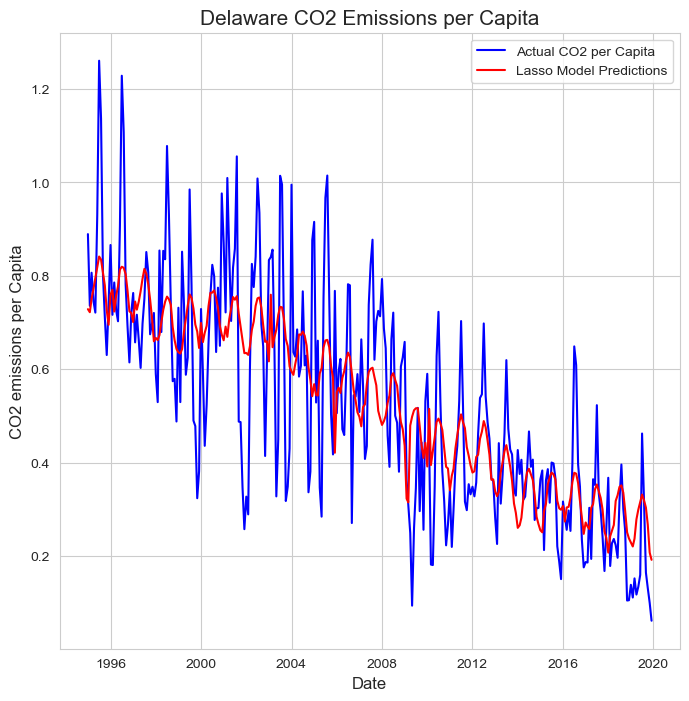

In [38]:
plt.figure(figsize=(8,8))

plt.plot(df_de_fillna['date'], df_de_fillna['co2_per_capita'], 'b-', label='Actual CO2 per Capita')
plt.plot(df_de_fillna['date'], lasso_preds, 'r-', label='Lasso Model Predictions')

plt.xlabel('Date', fontsize=12)
plt.ylabel('CO2 emissions per Capita', fontsize=12)
plt.legend()

plt.title("Delaware CO2 Emissions per Capita", fontsize=15)